In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q ogb>=1.3.0

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

from ipywidgets import interact, interact_manual
import pandas as pd
import torch

# Periodic table thanks to Chris Andrejewski <christopher.andrejewski@gmail.com>
link = "https://raw.githubusercontent.com/andrejewski/periodic-table/master/data.csv"
elements = pd.read_csv(
    link, index_col=0, sep=", ", engine="python",
     converters = dict(symbol= lambda text: text.strip())
)

# Molecules classification

## The dataset

We study the [`ogbg-molhiv` dataset][1].
Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not.

## The task

We want to predict whether a molecule inhibits HIV virus replication or not, as accurately as possible,

[1]: https://ogb.stanford.edu/docs/graphprop/

## Data Loading

In [2]:
AIDS_LABEL_ENC = pd.Series(data = [
    "C", "O", "N", "Cl", "F", "S",
    "Se", "P", "Na", "I", "Co", "Br",
    "Li", "Si", "Mg", "Cu", "As", "B",
    "Pt", "Ru", "K", "Pd", "Au", "Te",
    "W", "Rh", "Zn", "Bi", "Pb", "Ge",
    "Sb", "Sn", "Ga", "Hg", "Ho", "Tl",
    "Ni", "Tb"
])
print(len(AIDS_LABEL_ENC))

38


In [3]:
# IMPORTS
#from ogb.graphproppred import PygGraphPropPredDataset # Dataset package

from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader # Utility to load data
from torch_geometric.transforms import Compose

#### Transforms

To properly analyze the dataset, we need to define a few **transforms**.

In [4]:
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        #graph.symbols = elements.loc[graph.x[:,0] + 1, "symbol"].values
        graph.symbols = AIDS_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values
       
        return graph


In [5]:
from torch.nn.functional import one_hot

class OneHot(object):
    """ 
    Takes LongTensor with index values of shape (*) and returns a tensor of shape
    (*, num_classes) that have zeros everywhere except where the index of last
    dimension matches the corresponding value of the input tensor, in which case
    it will be 1.
    """
    def __init__(self, column=0, num_classes=-1):
        self.column = column
        self.num_classes = num_classes

    def __call__(self, graph):
        enc = one_hot(
            graph.x[:, self.column],
            num_classes=self.num_classes
        )

        x = torch.empty(
            (enc.shape[0], enc.shape[1] + graph.x.shape[1] - 1)
        )
    
        x[:, :self.column] = graph.x[:, :self.column]
        x[:, self.column:(self.column + enc.shape[1])] = enc
        x[:, (self.column + enc.shape[1]):] = graph.x[:, (self.column + 1):]
        graph.x = x

        return graph

    def __repr__(self):
        return f"OneHot(self.column={self.column}, num_classes={self.num_classes})"

In [6]:
# Download and process data at './ogbg_molhiv/'
# dataset = PygGraphPropPredDataset(
#     name = "ogbg-molhiv", root = '.',
#     pre_transform=Compose([
#         AddSymbols(),
#         OneHot(column=0,num_classes=118),
#     ])
# )

In [7]:
dataset = TUDataset(
    root=".", name="AIDS",
    transform=AddSymbols(),
).shuffle()

### Features

From the [doc](https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py).

**Atom** (node) features:
- atomic_num : cat (118 vals)
- chirality : cat (4 vals)
- degree : int (0 to 10)
- formal_charge : int (-5 to 5)
- numH : int (0 to 8)
- number_radical_e : int (0 to 4)
- possible hybridization : cat (5 vals)
- is_aromatic : bool
- is_in_ring : bool

**Bond** (edge) features:
- bond_type : cat (4 vals)
- bond_stereo : cat (6 vals)
- is_conjugated : bool

In [8]:
_el0 = dataset[0]
print(f"""
First element : {_el0}

Attributes : 
    - Node features : {_el0.num_node_features}
    - Edge features : {_el0.num_edge_features}
""")


First element : Data(edge_attr=[24, 3], edge_index=[2, 24], symbols=['O' 'C' 'N' 'C' 'C' 'C' 'C' 'N' 'N' 'N' 'C'], x=[11, 38], y=[1])

Attributes : 
    - Node features : 38
    - Edge features : 3



In [9]:
import numpy as np

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)

print(f"Unique: {len(np.unique(all_atoms))}")
print(np.unique(all_atoms))

Unique: 38
['As' 'Au' 'B' 'Bi' 'Br' 'C' 'Cl' 'Co' 'Cu' 'F' 'Ga' 'Ge' 'Hg' 'Ho' 'I'
 'K' 'Li' 'Mg' 'N' 'Na' 'Ni' 'O' 'P' 'Pb' 'Pd' 'Pt' 'Rh' 'Ru' 'S' 'Sb'
 'Se' 'Si' 'Sn' 'Tb' 'Te' 'Tl' 'W' 'Zn']


In [10]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

_el0 = dataset[0]  # Get the first graph object.

print()
print(_el0)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {_el0.num_nodes}')
print(f'Number of edges: {_el0.num_edges}')
print(f'Average node degree: {_el0.num_edges / _el0.num_nodes:.2f}')
print(f'Contains isolated nodes: {_el0.contains_isolated_nodes()}')
print(f'Contains self-loops: {_el0.contains_self_loops()}')
print(f'Is undirected: {_el0.is_undirected()}')


Dataset: AIDS(2000):
Number of graphs: 2000
Number of features: 38
Number of classes: 2

Data(edge_attr=[24, 3], edge_index=[2, 24], symbols=['O' 'C' 'N' 'C' 'C' 'C' 'C' 'N' 'N' 'N' 'C'], x=[11, 38], y=[1])
Number of nodes: 11
Number of edges: 24
Average node degree: 2.18
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Visualization

We will use a graph visualization library to represent the molecules.

_NOTE: consider writing interactively the basic plot function:_
```
    torch_graph -> networkx.Graph
    networkx.draw(networkx.Graph)
```

In [13]:
# DEFINE VISUALIZATION FUNCTIONS
import networkx as nx  # Graph manipulation library
from torch_geometric.utils import to_networkx  # Conversion function

def ogb_graph_to_mol(torch_graph, remove_isolated=True):
    G = to_networkx(
        torch_graph,
        to_undirected=True,
        node_attrs=["symbols"]
    )

    return G


def plot_mol(
    G: nx.Graph,
    edge_mask=None,
    edge_type=None,
    draw_edge_labels=False
):
    fig, ax = plt.subplots(dpi=120)

    node_labels = {
        u: data["symbols"] for u, data in G.nodes(data=True)
    }

    pos = nx.planar_layout(G)
    pos = nx.kamada_kawai_layout(G, pos=pos)

    if edge_type is None:
        widths = None
    else:
        widths = edge_type + 1

    if edge_mask is None:
        edge_color = 'black'
    else:
        edge_color = [edge_mask[(u, v)] for u, v in G.edges()]

    nx.draw_networkx(
        G, pos=pos,
        node_size=350,
        labels=node_labels,
        width=widths,
        edge_color=edge_color, edge_cmap=plt.cm.Blues,
        node_color='azure'
    )

    fig.tight_layout()
    plt.show()


In [14]:
interact(
    lambda graph: plot_mol(
        ogb_graph_to_mol(dataset[graph]),
        edge_type=dataset[graph].edge_attr[:,0].numpy()
    ),
    graph=range(len(dataset))
)

interactive(children=(Dropdown(description='graph', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.<lambda>>

## Graph neural networks

We will use the [**Pytorch Geometric**][1] library to define a message passing network and use it for classification.

_NOTE: One should use this notebook to explain some backgroud on graph convolutions_

[1]: https://pytorch-geometric.readthedocs.io/en/latest/

In [15]:
# IMPORTS
import torch  # Computational module

from torch.nn import Linear, NLLLoss, Sigmoid, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv, global_add_pool

### Model definition

Let's start with an easy example.
We will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.


In [17]:
class GNN(torch.nn.Module):
    def __init__(
        self,
        hidden_channels,
        hidden_nodes,
        node_features=dataset.num_node_features,
        edge_features=dataset.num_edge_features
    ):
        super(GNN, self).__init__()
        self.hidden_channels = hidden_channels

        self.conv1 = GraphConv(node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.conv5 = GraphConv(hidden_channels, hidden_channels)

        self.fc1 = Linear(hidden_channels, hidden_channels)
        self.fc2 = Linear(hidden_channels, dataset.num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        x = F.relu(self.conv4(x, edge_index, edge_weight))
        x = F.relu(self.conv5(x, edge_index, edge_weight))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)

### Training

In [18]:
from torch_geometric.data import DataLoader

from tqdm.auto import tqdm

# If possible, we use a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
def test(model, loader):
    model.eval()

    y_preds = []
    y_trues = []

    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_preds.append(out.argmax(dim=1))  # Use the class with highest probability.
        y_trues.append(data.y)  # Check against ground-truth labels.
    
    y_pred = torch.cat(y_preds).flatten()
    y_true = torch.cat(y_trues).flatten()

    return torch.sum(y_pred == y_true).item() / len(y_true)  # Derive ratio of correct predictions.

In [22]:
idx_tr, idx_val, idx_te = int(len(dataset) * .5) , int(len(dataset) * .7), len(dataset)

# NOTE: time per epoch by batch_size
# 128 -> 5.35s
# 256 -> 5.20s
batch_size = 128

loader_tr = DataLoader(dataset[:idx_tr], batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset[idx_tr:idx_val], batch_size=batch_size, shuffle=True)
loader_te = DataLoader(dataset[idx_val:], batch_size=batch_size, shuffle=False)

In [23]:
model = GNN(
    hidden_channels=64,
    hidden_nodes=64
).to(device)
optimizer = torch.optim.Adam(params=model.parameters())
loss_function = NLLLoss()

train_losses = []
train_accs = []
val_accs = []

In [24]:
for epoch in tqdm(range(50)):
    epoch_loss = 0
    for batch in tqdm(loader_tr, leave=False):
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_function(out, batch.y.flatten())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += loss.item()

    with torch.no_grad():
        train_accs.append(test(model, loader_tr))
        val_accs.append(test(model, loader_val))
        train_losses.append(epoch_loss)

In [25]:
# Let's save the model for future usage

torch.save(model.state_dict(), "mol_classifier.pt")

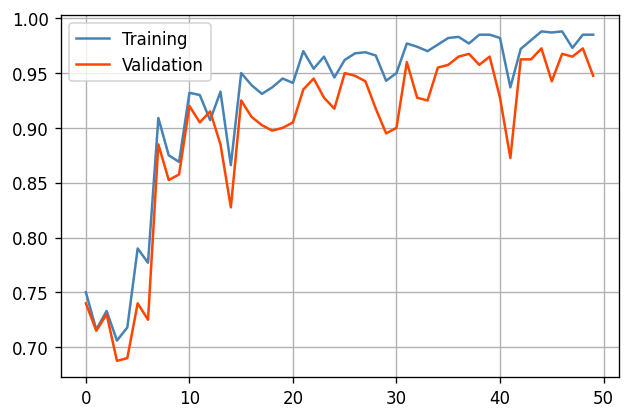

In [26]:
# TRAINING VISUALIZATION

fig, ax = plt.subplots(dpi=120)

ax.plot(train_accs, c="steelblue", label="Training")
ax.plot(val_accs, c="orangered", label="Validation")
ax.grid()
ax.legend()

plt.show()

As multiple papers pointed out ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), applying **neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures**.
An alternative formulation ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)) omits neighborhood normalization completely and adds a simple skip-connection to the GNN layer in order to preserve central node information:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.

### Evaluation

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
with torch.no_grad():
    model.eval()

    outs = []
    for batch in tqdm(loader_te):
        batch.to(device)
        outs.append(model(batch.x, batch.edge_index, batch.batch))

    y_pred = torch.cat(outs).argmax(dim=1)
    del outs

In [31]:
cm = confusion_matrix(y_true.flatten().cpu(), y_pred.cpu())
print(f"""
Confusion matrix:
{cm}

Accuracy: {
    ((y_true.flatten().cpu() == y_pred.cpu()).sum() / len(y_pred)).item()
}
""")


Confusion matrix:
[[120  10]
 [ 10 460]]

Accuracy: 0.9666666388511658



In [32]:
print(f"Negative samples : {(1 - y_true).sum().item()}, Positive samples : {y_true.sum().item()}")

Negative samples : 130, Positive samples : 470
